In [1]:
import random, copy, path
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 50)
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import colorConverter
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
%matplotlib inline
import seaborn as sns
from pylab import *
from Bio import SeqIO
from Bio import SeqUtils
AA_symbols = {'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'}

## Computational estimate of amino acid abundance of proteins in common cell lines
Here, I attempt to determine the molar fraction of each amino acid in the total proteome of a common cell line.
For instance, if the molar fraction of aspartate was found to be 5%, that would mean that the moles of aspartate constitute 5% of the total moles of amino acids.
To calculate this I need data on the protein copy number (or relative molarity) and the protein sequences.
Data on protein copy number can be found in whole cell proteomics datasets whereas their protein sequences can be downloaded from UniProt.

I use the data from Geiger et al 2012 (https://www.sciencedirect.com/science/article/pii/S1535947620305004?via%3Dihub), stored in Supplementary Table 3.
Here, the iBAQ values are of use as these are approximately proportional to the molar amount (assuming equal ionization efficiency).

The full human proteome is downloaded from UniProt and saved as a fasta file:
https://www.uniprot.org/uniprot/?query=human+AND+organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22&sort=score


In [2]:
# Read the all sequences of the full human proteome (from UniProt):
seq_file = 'human_proteins.fasta'
id2seq = dict()
for record in SeqIO.parse(seq_file, "fasta"):
    ID = record.id.split('|')[1]
    seq = str(record.seq)
    ### Non unresolved amino acids are so few that they are neglegible ###
    # Removing unresolved amino acids:
    ca = [AA for AA in seq if AA in AA_symbols]
    id2seq[ID] = ''.join(ca)

In [3]:
# Read the proteomics data:
fnam = 'Geiger_2012_data.xlsx'
df = pd.read_excel(fnam, skiprows=[0])
# Require Uniprot ID:
df = df[~df['Uniprot'].isnull()]

# Fix Uniprot IDs and add sequences and molecular weight:
uid_list = list()
seq_list = list()
mw_list = list()
for uid_str in df['Uniprot'].values:
    uids = uid_str.split(';')
    uid_saved = False
    for uid in uids:
        if uid in id2seq:
            uid_list.append(uid)
            seq_list.append(id2seq[uid])
            mw = SeqUtils.molecular_weight(id2seq[uid], seq_type='protein')
            mw_list.append(mw/1000)
            uid_saved = True
            break
    if not uid_saved:
        uid_list.append(np.nan)
        seq_list.append('')
        mw_list.append(0)
df['Uniprot'] = uid_list
df['Seq'] = seq_list
df['MW_calc'] = mw_list
# Remove rows with no sequence:
df = df[~df['Uniprot'].isnull()]
# Filter if molecular weight does not match:
df = df[np.isclose(df['Mol. Weight [kDa]'].values, df['MW_calc'].values, atol=0.1)]
# Trim columns:
df = df.drop(['Protein IDs', 'Protein Names', 'Gene Names', 'Peptides', 'Razor + unique Peptides', 'Unique Peptides', 'Sequence Coverage [%]', 'Mol. Weight [kDa]', 'PEP'], axis=1)

# Take the mean of the three replicates:
cell_lines = sorted({cid[5:-2] for cid in df.columns[df.columns.str.contains('iBAQ')]})
for cell_line in cell_lines:
    rep_cols = list()
    for rep in range(1, 4):
        rep_str = 'iBAQ {}_{}'.format(cell_line, rep)
        rep_cols.append(rep_str)
    mean_col = '{} mean'.format(cell_line)
    # Notice that iBAQ values are also transformed back from log space:
    df[mean_col] = (10**df.loc[:, rep_cols]).mean(axis=1, skipna=False)

# Remove rows if all means are null values:
df = df[~df.loc[:, df.columns.str.contains(' mean')].isnull().all(axis=1)]
# Remove replicate columns:
df = df.loc[:,~df.columns.str.contains('iBAQ')]
# Fill NaN with 0:
df = df.fillna(0)

In [4]:
df

,Uniprot,Seq,MW_calc,A549 mean,GAMG mean,HEK293 mean,HeLa mean,HepG2 mean,Jurkat mean,K562 mean,LnCap mean,MCF7 mean,RKO mean,U2OS mean
1,Q8IZV2,MEEPQRARSHTVTTTASSFAENFSTSSSSFAYDREFLRTLPGFLIV...,19.572208,0.000000e+00,0.000000e+00,2.261992e+06,0.000000e+00,1.075234e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,Q9BX73,MVLGGCPVSYLLLCGQAALLLGNLLLLHCVSRSHSQNATAEPELTS...,22.870852,5.203691e+05,0.000000e+00,0.000000e+00,9.872965e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,P27449,MSESKSGPEYASFFAVMGASAAMVFSALGAAYGTAKSGTGIAAMSV...,15.735571,0.000000e+00,0.000000e+00,5.174815e+07,1.016901e+07,0.000000e+00,0.000000e+00,4.137481e+06,0.000000e+00,0.000000e+00,8.031462e+06,7.875699e+06
7,B4E171,MGRVFLTGEKANSILKRYPRANGFFEEIRQGNIERECKEEFCTFEE...,31.090420,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.125142e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
15,Q9NPI0,MLQTSNYSLVLSLQFLLLSYDLFVNSFSELLQKTPVIQLVLFIIQD...,19.261718,0.000000e+00,1.533170e+06,3.132192e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.342383e+05,8.268027e+05,0.000000e+00,1.650000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11718,P35579,MAQQAADKYLYVDKNFINNPLAQADWAAKKLVWVPSDKSGFEPASL...,226.529635,7.462897e+07,3.519300e+08,8.340237e+07,4.271900e+07,5.585969e+06,7.731092e+07,8.442027e+06,7.245865e+07,3.303868e+07,2.044816e+07,3.298132e+08
11722,P78527,MAGSGAGVRCSLLRLQETLSAADRCGAALAGHQLIRGLGQECVLSS...,469.083478,2.044741e+07,2.511465e+07,4.426266e+07,2.019435e+07,1.371867e+07,1.091376e+07,7.317935e+06,6.144134e+07,3.135934e+07,9.250940e+06,3.273829e+07
11723,Q14204,MSEPGGGGGEDGSAGLEVSAVQNVADVSVLQKHLRKLVPLLLEDGG...,532.401351,1.158343e+07,2.493200e+07,4.272232e+07,7.571832e+06,9.694601e+06,7.170372e+06,4.629198e+06,1.729774e+07,1.577389e+07,7.752299e+06,2.787533e+07
11729,Q15149,MVAGMLMPRDQLRAIYEVLFREGVMVAKKDRRPRSLHPHVPGVTNL...,531.784261,5.605271e+07,7.110231e+07,2.620565e+06,3.476670e+07,3.337633e+06,1.034403e+06,7.268167e+05,4.362735e+06,4.694032e+07,1.730423e+06,1.496560e+08


In [5]:
# Tally the abundance of each amino acid:
AA_abundance = pd.DataFrame(columns=[sorted(AA_symbols)], index=sorted(cell_lines))
for cell_line in cell_lines:
    mean_col = '{} mean'.format(cell_line)
    abd_row = {AA: 0 for AA in AA_symbols}
    for ibaq, seq in zip(df[mean_col].values, df['Seq'].values):
        for AA in seq:
            abd_row[AA] += ibaq
    # Find the molar frequency and add to dataframe:
    ibaq_sum = sum(list(abd_row.values()))
    AA_abundance.loc[cell_line, :] = [abd_row[k]/ibaq_sum for k in sorted(abd_row.keys())]
# Getting rid of multiindex:
AA_abundance.columns = AA_abundance.columns.map(lambda x: x[0])
AA_abundance = AA_abundance.reset_index().rename(columns={'index': 'Cell line'})
# Flatten for plotting:
AA_abundance_flat = pd.melt(AA_abundance, id_vars=['Cell line']).rename(columns={'variable': 'Amino acid', 'value': 'Molar fraction'})

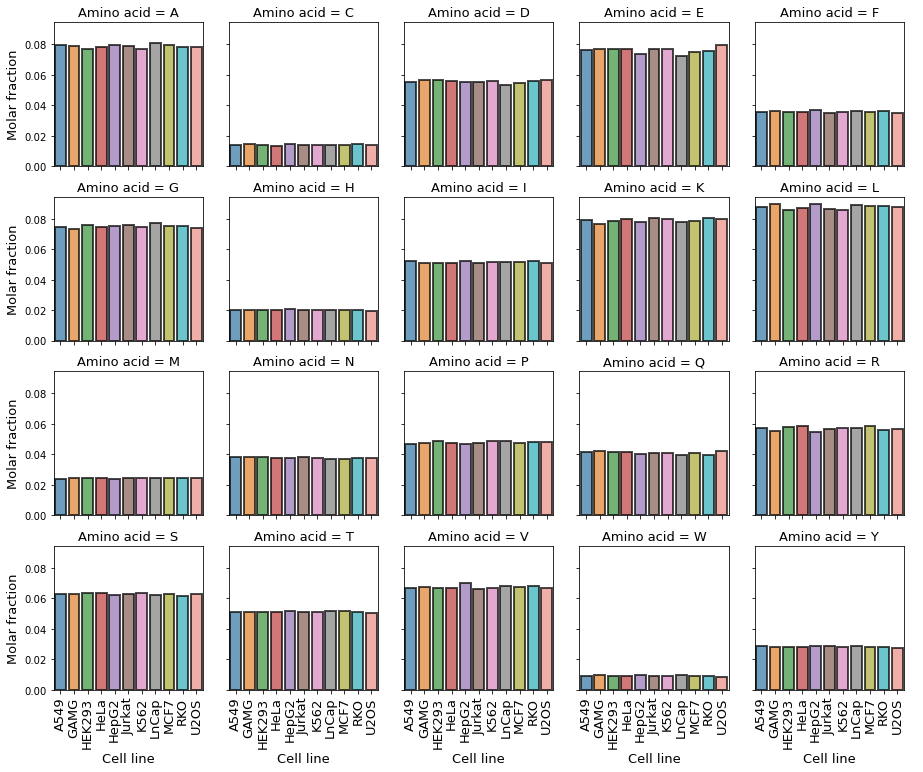

In [6]:
# Plot the data:
sns_fig = sns.FacetGrid(AA_abundance_flat, col='Amino acid', height=2.5, col_wrap=5, despine=False)
sns_fig.map_dataframe(sns.barplot, x='Cell line', y='Molar fraction', capsize=.1, errwidth=2, dodge=False, edgecolor='black', linewidth=2, alpha=0.7, palette=palette)
sns_fig.set_axis_labels('Cell line', 'Molar fraction', size=13)
sns_fig.set_xticklabels(size=13, rotation=90)
sns_fig.set_titles(size=13)
sns_fig.add_legend()
sns_fig.savefig('AA_predicted_molar-fraction.pdf', bbox_inches='tight')

In [7]:
# Write the abundance:
AA_abundance.to_excel('AA_predicted_molar-fraction.xlsx', index=False)
# And the mean of all the cell lines:
AA_abundance.loc[:, AA_abundance.columns != 'Cell line'].mean().to_frame().T.to_excel('AA_predicted_molar-fraction_mean.xlsx', index=False)